In [1]:
import numpy as np
import pandas as pd
testred=pd.read_csv('redshift.csv',header=None)
testred=np.array(testred)
testdata=pd.read_csv('data_norm.csv',header=None)
testdata=np.array(testdata)

In [2]:
testred.shape

(415930, 1)

In [3]:
testdata.shape

(415930, 3600)

In [4]:
#model

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.utils import np_utils
import keras.backend as K
from keras.layers import *
from keras.models import Model


zhongzi = 6
#kernel_initializer=initializers.random_uniform(seed = zhongzi)
#kernel_initializer=initializers.glorot_uniform(seed = zhongzi)

def squeeze(x):
    s = x[:,:,0]
    for i in range(1,x.shape[2]):
        s = s + x[:,:,i]
    return s

def BLOCK0(seq, filters): # 定义网络的BlockL
    cnn = Conv1D(filters*2, 3, padding='SAME', dilation_rate=1, activation='relu')(seq)
    cnn = Lambda(lambda x: x[:,:,:filters] + x[:,:,filters:])(cnn)
    cnn = Conv1D(filters*2, 3, padding='SAME',  dilation_rate=1, activation='relu')(cnn)
    cnn = Lambda(lambda x: x[:,:,:filters] + x[:,:,filters:])(cnn)
    cnn = Conv1D(filters*2, 3, padding='SAME', dilation_rate=1, activation='relu')(cnn)
    cnn = Lambda(lambda x: x[:,:,:filters] + x[:,:,filters:])(cnn)
    if int(seq.shape[-1]) != filters:
        seq = Conv1D(filters, 1, padding='SAME')(seq)
    seq = add([seq, cnn])
    return seq
def attblock(cnn,filters):
    GP = GlobalMaxPooling1D()(cnn)
    AP = GlobalAveragePooling1D()(cnn)
    P = keras.layers.concatenate([GP,AP])
    att = Dense(filters,activation = 'relu')(P)
    att = RepeatVector(cnn.shape[1])(att)
    cnn = Multiply()([att,cnn])
    return cnn
def BLOCK(seq, filters): # 定义网络的Block
    cnn = Conv1D(filters, 3, padding='SAME', dilation_rate=1, activation='relu')(seq)
    cnn = attblock(cnn,filters)
    cnn = Conv1D(filters, 3, padding='SAME', dilation_rate=2, activation='relu')(cnn)
    cnn = attblock(cnn,filters)
    cnn = Conv1D(filters, 3, padding='SAME', dilation_rate=4, activation='relu')(cnn)
    cnn = attblock(cnn,filters)
    #print('cnn',int(cnn.shape[2]))
    if int(seq.shape[-1]) != filters:
        seq = Conv1D(int(cnn.shape[2]), 1, padding='SAME')(seq)
    #print('seq',int(seq.shape[2]))
    seq = add([seq, cnn])
    return seq

input_dims = 3600
inputs = Input(shape=(input_dims,))
reshape = Reshape((3600, 1), input_shape=(3600,))(inputs)
seq = reshape

seq = BLOCK(seq, 128)
seq = MaxPooling1D(2)(seq)
seq = BLOCK(seq, 64)
seq = MaxPooling1D(2)(seq)
seq = BLOCK(seq, 32)
seq = MaxPooling1D(2)(seq)
seq = BLOCK(seq, 16)
seq = MaxPooling1D(2)(seq)
seq = Dropout(0.5)(seq)

seq = Flatten()(seq)
seq = Dense(2048, activation='relu')(seq)
seq = Dropout(0.5)(seq)
seq = Dense(1024, activation='relu')(seq)
seq = Dropout(0.5)(seq)
seq = Dense(512, activation='relu')(seq)
seq = Dropout(0.5)(seq)
seq = Dense(256, activation='relu')(seq)
seq = Dropout(0.5)(seq)
seq = Dense(128, activation='relu')(seq)
seq = Dense(64, activation='relu')(seq)
seq = Dense(32, activation='relu')(seq)
seq = Dense(16, activation='relu')(seq)
seq = Dense(8, activation='relu')(seq)
output_tensor = Dense(1)(seq)
model = Model(inputs=[inputs], outputs=output_tensor)
print(model.summary())

Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3600)         0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 3600, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 3600, 128)    512         reshape_1[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 128)          0           conv1d_1[0][0]                   
____________________________________________________________________________________________

In [5]:
#import os
#from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
#from keras.optimizers import *
# 数据集切分
(trainX, testX, trainY, testY) = train_test_split(testdata,testred, test_size=0.2, random_state=42)   


from keras.optimizers import Adam
from keras.layers import *

#train model setting
#from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
#from tensorflow.keras.optimizers import *
#os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ['CUDA_VISIBLE_DEVICES']='1'



#callbacks = [EarlyStopping(patience=3), CSVLogger('model/cnn_red128-att.csv'), 
#             ModelCheckpoint('model/Restesst_red128-att.h5', save_best_only=True,save_weights_only = False)]

model.compile(loss='mean_absolute_error',
              optimizer=Adam(1e-3, amsgrad=True), 
              metrics=['mse'])
H1 = model.fit(trainX,trainY, epochs=30,validation_data = (testX,testY), workers=4, use_multiprocessing=True,
                      batch_size = 512)


Train on 332744 samples, validate on 83186 samples
Epoch 1/30
332744/332744 [==============================] - 12104s 36ms/step - loss: 0.2858 - mse: 0.2112 - val_loss: 0.1716 - val_mse: 0.0841
Epoch 2/30
332744/332744 [==============================] - 11851s 36ms/step - loss: 0.0932 - mse: 0.0473 - val_loss: 0.0890 - val_mse: 0.0441
Epoch 3/30
332744/332744 [==============================] - 11580s 35ms/step - loss: 0.0780 - mse: 0.0431 - val_loss: 0.0763 - val_mse: 0.0405
Epoch 4/30
332744/332744 [==============================] - 11516s 35ms/step - loss: 0.0717 - mse: 0.0412 - val_loss: 0.0642 - val_mse: 0.0378
Epoch 5/30
332744/332744 [==============================] - 11402s 34ms/step - loss: 0.0678 - mse: 0.0396 - val_loss: 0.0598 - val_mse: 0.0349
Epoch 6/30
332744/332744 [==============================] - 11441s 34ms/step - loss: 0.0649 - mse: 0.0385 - val_loss: 0.0604 - val_mse: 0.0372
Epoch 7/30
332744/332744 [==============================] - 11485s 35ms/step - loss: 0.063

# ------------------------------------------

# 只保存模型训练好的参数，下次使用时，先构建前面的模型，再用model.load_weights函数赋参数值

In [6]:
from keras.models import *
model.save_weights('specmodel-att_weights.h5')

In [7]:
model1 = model

In [8]:
model1.load_weights('specmodel-att_weights.h5')

In [9]:
print(testY)
pred1 = model1.predict(testX)
print(pred1)

[[1.19326 ]
 [1.665689]
 [1.80627 ]
 ...
 [1.88411 ]
 [1.891038]
 [1.217254]]
[[1.2011185]
 [1.6760769]
 [1.8084489]
 ...
 [1.9050778]
 [1.896255 ]
 [1.2226912]]


# -----------------------------------

In [10]:
print(testY)
pred = model.predict(testX)
print(pred)

[[1.19326 ]
 [1.665689]
 [1.80627 ]
 ...
 [1.88411 ]
 [1.891038]
 [1.217254]]
[[1.2011185]
 [1.6760769]
 [1.8084489]
 ...
 [1.9050778]
 [1.896255 ]
 [1.2226912]]


In [11]:
print(min(pred))
print(max(pred))

[1.0108384]
[4.164788]


In [12]:
np.savetxt('prediction-spec128_att.csv', pred, delimiter=',', fmt='%s')
np.savetxt('redshift-spec128_att.csv', testY, delimiter=',', fmt='%s')

In [18]:
'''
print(trainY)
pred_train = model.predict(trainX)
print(pred_train)
'''

[[1.896913]
 [1.822035]
 [1.570794]
 ...
 [3.944293]
 [2.184062]
 [3.670791]]
[[1.9156358]
 [1.8142262]
 [1.5732976]
 ...
 [3.8911445]
 [2.2031343]
 [3.6743143]]


In [19]:
'''
np.savetxt('prediction-spec128_trainatt.csv', pred_train, delimiter=',', fmt='%s')
np.savetxt('redshift-spec128_trainatt.csv', trainY, delimiter=',', fmt='%s')
'''

In [20]:
'''
np.savetxt('trainX128_att.csv', trainX, delimiter=',', fmt='%s')
np.savetxt('testX128_att.csv', testX, delimiter=',', fmt='%s')
'''

In [13]:
#保存128维模型
test=Model(inputs=model.get_layer('input_1').input,outputs=model.get_layer('dense_17').output)

In [14]:
test.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3600)         0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 3600, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 3600, 128)    512         reshape_1[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 128)          0           conv1d_1[0][0]                   
____________________________________________________________________________________________

In [15]:
y1=test.predict(testdata)


In [16]:
np.savetxt('data128_att.csv',y1,delimiter=',',fmt='%s')

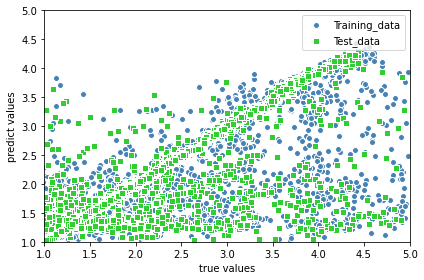

In [25]:
'''
# 绘制散点图
import matplotlib.pyplot as plt
plt.scatter(trainY, model.predict(trainX),
            c='steelblue', marker='o', edgecolor='white',
            label='Training_data')
plt.scatter(testY, pred,
            c='limegreen', marker='s', edgecolor='white',
            label='Test_data')
plt.xlabel('true values')
plt.ylabel('predict values')
plt.legend(loc='upper right')
#plt.hlines(y=0, xmin=0.9, xmax=2.0, color='black', lw=2)
plt.xlim([1, 5]) # 设置坐标轴的取值范围
plt.ylim([1, 5])
plt.tight_layout()
plt.show()
'''

In [17]:
res = pred - testY
print(min(res))
print(max(res))

[-3.87764338]
[2.15750173]


In [18]:
res=np.array(res)
print(res.shape)

(83186, 1)


In [19]:
res=res.reshape(83186,)

In [20]:
#a=pd.cut(res,[-2.35,-2.25,-2.15,-2.05,-1.95,-1.85,-1.75,-1.65,-1.55,-1.45,-1.35,-1.25,-1.15,-1.05,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.05,1.15,1.25,1.35,1.45,1.55,1.65,1.75], 
#         labels=[u"(-0.3,-0.25]",u"(3,6]",u"(6,9]",u"(9,12]",u"(12,15]"])

bins = [-2.15,-2.05,-1.95,-1.85,-1.75,-1.65,-1.55,-1.45,-1.35,-1.25,-1.15,-1.05,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.05,1.15,1.25,1.35,1.45, 1.55,1.65,1.75,1.85,1.95,2.05,2.15]
cats = pd.cut(res, bins, right=True, duplicates='drop') #左开右闭

In [21]:
cats.value_counts()

(-2.15, -2.05]       11
(-2.05, -1.95]       15
(-1.95, -1.85]       18
(-1.85, -1.75]       18
(-1.75, -1.65]       22
(-1.65, -1.55]       18
(-1.55, -1.45]       27
(-1.45, -1.35]       21
(-1.35, -1.25]       23
(-1.25, -1.15]       34
(-1.15, -1.05]       38
(-1.05, -0.95]       69
(-0.95, -0.85]       98
(-0.85, -0.75]      178
(-0.75, -0.65]      161
(-0.65, -0.55]       93
(-0.55, -0.45]      146
(-0.45, -0.35]      144
(-0.35, -0.25]      421
(-0.25, -0.15]     1356
(-0.15, -0.05]     2049
(-0.05, 0.05]     76379
(0.05, 0.15]        939
(0.15, 0.25]        320
(0.25, 0.35]        204
(0.35, 0.45]         67
(0.45, 0.55]         57
(0.55, 0.65]         27
(0.65, 0.75]         26
(0.75, 0.85]         20
(0.85, 0.95]          6
(0.95, 1.05]          2
(1.05, 1.15]          5
(1.15, 1.25]          4
(1.25, 1.35]          6
(1.35, 1.45]          1
(1.45, 1.55]          1
(1.55, 1.65]          2
(1.65, 1.75]          1
(1.75, 1.85]          0
(1.85, 1.95]          0
(1.95, 2.05]    

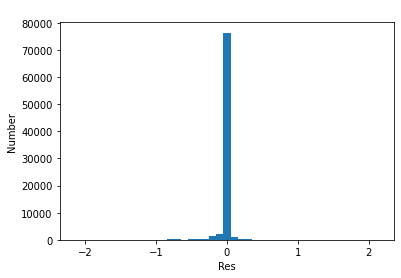

In [22]:
import pylab as pl
def draw_hist(lenths):  #lenths 接受的其实是 sizeArry传来的数组 就是def get_data(lines) 返回的数据
    data = lenths 

# 对数据进行切片，将数据按照从最小值到最大值分组，分成20组
    bins = [-2.15,-2.05,-1.95,-1.85,-1.75,-1.65,-1.55,-1.45,-1.35,-1.25,-1.15,-1.05,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.05,1.15,1.25,1.35,1.45, 1.55,1.65,1.75,1.85,1.95,2.05,2.15]

# 这个是调用画直方图的函数，意思是把数据按照从bins的分割来画
    pl.hist(data,bins)
#设置出横坐标
    pl.xlabel('Res')
#设置纵坐标的标题
    pl.ylabel('Number')
#设置整个图片的标题
    pl.title(' ')

# 展示出我们的图片
    pl.show()
    
draw_hist(res)

In [23]:
testY2 = testY.T
pred2 = pred.T
print(testY2.shape)
print(pred2.shape)

(1, 83186)
(1, 83186)


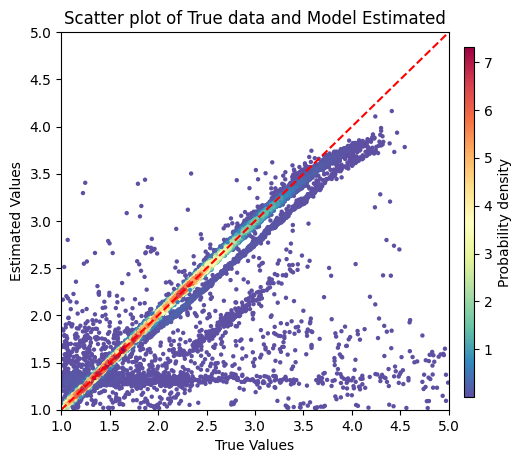

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm

x2 = np.linspace(-10,10)
y2=x2
x=testY2#第一维数据
y=pred2#第二维数据
xy = np.vstack([x,y])#将两个维度的数据进行叠加
kenal = gaussian_kde(xy)#这一步根据xy这个样本数据，在全定义域上建立了概率密度分布，所以kenal其实就是一个概率密度函数，输入对应的(x,y)坐标，就给出相应的概率密度
z = kenal.evaluate(xy)#得到我们每个样本点的概率密度
z = gaussian_kde(xy)(xy)#这行代码和上面两行是相同的意思，这行是一行的写法
idx = z.argsort() #对z值进行从小到大排序并返回索引
# x, y, z = x[idx], y[idx], z[idx]#对x,y按照z的升序进行排列
#上面两行代码是为了使得z值越高的点，画在上面，不被那些z值低的点挡住，从美观的角度来说还是十分必要的
fig, ax = plt.subplots(figsize=(5,5),dpi=100)
scatter = ax.scatter(x,y,marker='o',c=z,edgecolors='none',s=10,label='label'
                     ,cmap='Spectral_r')
cbar_ax = plt.gcf().add_axes([0.93, 0.15, 0.02, 0.7])#[left,bottom,width,height] position
cbar = fig.colorbar(scatter, cax=cbar_ax, label='Probability density')
ax.set_xlabel('True Values')
ax.set_ylabel('Estimated Values')
ax.set_title('Scatter plot of True data and Model Estimated')
ax.set_xlim((1, 5.0))
ax.set_ylim((1, 5.0))
ax.plot(x2,y2,color='r' ,linewidth=1.5,linestyle='--')

#plt.savefig('spec-pred128.jpg')